# Simple properties of the learners: do they find the correct constant policies?

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import pandas as pd

## Step 1: finding a parameter range that explores different policies


In [2]:
%run groundTruth.py

Text(0, 0.5, 'Optimal action')

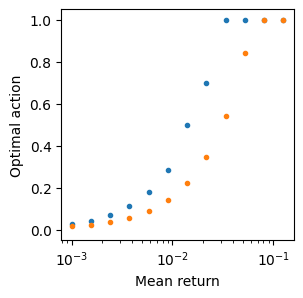

In [78]:
mus = np.logspace(-3, -0.9, 12)
actions_sqrt = []
actions_log = []

figsize(3,3)

for mu in mus:
    actions_sqrt.append( findBestAction_determ(mu, 0.25, 1., np.sqrt).x[0] )
    actions_log.append( findBestAction_determ(mu, 0.25, 1., np.log).x[0] )
    
plt.semilogx(mus, actions_sqrt, '.')
plt.semilogx(mus, actions_log, '.')
plt.ylim([-0.05, 1.05])
plt.xlabel('Mean return')
plt.ylabel('Optimal action')

### This is a nice range of means that allows both utility functions to explore a range of optimal allocations

Text(0, 0.5, 'Optimal action')

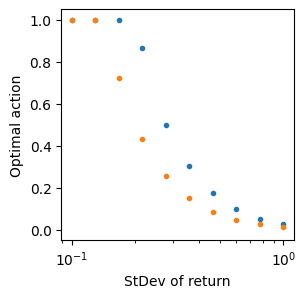

In [79]:
sigmas = np.logspace(-1, 0., 10)
actions_sqrt = []
actions_log = []

figsize(3,3)

for sigma in sigmas:
    actions_sqrt.append( findBestAction_determ(0.02, sigma, 1., np.sqrt).x[0] )
    actions_log.append( findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
    
plt.semilogx(sigmas, actions_sqrt, '.')
plt.semilogx(sigmas, actions_log, '.')
plt.ylim([-0.05, 1.05])
plt.xlabel('StDev of return')
plt.ylabel('Optimal action')

### This is a good range of standard deviations.

## Step 2: Double checking against the sampling approach

The sampler uses the same statistics as the learners. Double checking consistency here.

In [ ]:
# this is slow, but its worth double checking

from scipy.stats import ttest_1samp

muDifferences = pd.DataFrame(columns=['mu', 'util', 'p', 'diff'])
sigmaDifferences = pd.DataFrame(columns=['sigma', 'util', 'p', 'diff'])


for mu in mus:
    for utilityFn in [np.sqrt, np.log]:
        baseline = findBestAction_determ(mu, 0.25, 1., utilityFn).x[0]
        samples = []
        for sampleN in range(200):
            samples.append( findBestAction(mu, 0.25, 1., utilityFn).x[0] )

        print('m', mu)
        P = ttest_1samp(samples, baseline).pvalue
        diff = np.mean(samples) - baseline
        row = pd.DataFrame([{'mu': mu,'util':str(utilityFn),'p': P,'diff': diff}])
        muDifferences = pd.concat( [muDifferences, row], ignore_index=True)
        

for sigma in sigmas:
    for utilityFn in [np.sqrt, np.log]:
        baseline = findBestAction_determ(0.02, sigma, 1., utilityFn).x[0]
        samples = []
        for sampleN in range(200):
            samples.append( findBestAction(0.02, sigma, 1., utilityFn).x[0] )

        print('s', sigma)
        P = ttest_1samp(samples, baseline).pvalue
        diff = np.mean(samples) - baseline
        row = pd.DataFrame([{'sigma':sigma,'util':str(utilityFn), 'p': P, 'diff': diff}])
        sigmaDifferences = pd.concat( [sigmaDifferences, row], ignore_index=True)
        

In [155]:
muDifferences

,mu,util,p,diff
0,0.001000,<ufunc 'sqrt'>,2.953693e-09,4.891647e-03
1,0.001000,<ufunc 'log'>,3.664106e-02,-8.678654e-04
2,0.001552,<ufunc 'sqrt'>,9.424027e-08,4.664907e-03
3,0.001552,<ufunc 'log'>,1.484969e-01,-5.352116e-04
4,0.002409,<ufunc 'sqrt'>,5.581269e-04,3.049392e-03
5,0.002409,<ufunc 'log'>,3.246900e-01,-4.261821e-04
6,0.003739,<ufunc 'sqrt'>,1.511952e-08,4.609161e-03
7,0.003739,<ufunc 'log'>,1.662824e-23,4.541669e-03
8,0.005803,<ufunc 'sqrt'>,3.727911e-02,1.792862e-03
9,0.005803,<ufunc 'log'>,3.009851e-16,3.518838e-03


In [144]:
sigmaDifferences

,sigma,util,p,diff
0,0.100000,<ufunc 'sqrt'>,1.754497e-01,1.347948e-10
1,0.100000,<ufunc 'log'>,1.234404e-02,-1.931788e-13
2,0.129155,<ufunc 'sqrt'>,2.602750e-02,-1.938449e-13
3,0.129155,<ufunc 'log'>,1.704846e-04,-3.885781e-15
4,0.166810,<ufunc 'sqrt'>,8.818402e-02,-7.993606e-15
5,0.166810,<ufunc 'log'>,8.567265e-01,1.166584e-04
6,0.215443,<ufunc 'sqrt'>,6.106401e-02,-1.673284e-03
7,0.215443,<ufunc 'log'>,5.022880e-01,3.323196e-04
8,0.278256,<ufunc 'sqrt'>,3.209623e-54,1.631573e-02
9,0.278256,<ufunc 'log'>,5.088905e-05,1.539331e-03


### Ok, this is not quite as clear of a signal as I was hoping for. 

Many of the results are, in fact, not significantly different, as you would hope. However, there are quite a few that are significantly different. 

 - Of course, we are doing a lot of tests, so it is quite likely that some of the sampled p-values would be small.
 
 - It's also possible that the noise is non-Gaussian, impacting the test: it comes out of a maximization process, and the results are limited to the range [0,1] 
 
How to proceed?

 - Many of the differences, while significant, are small. In some sense, this sets a bound on the accuracy that we can expect from the learners.

### looking into the biggest differences

In [231]:
muDifferences[ (muDifferences['diff'].abs() > 1E-3) & ((muDifferences.p) < 1E-3 )]

,mu,util,p,diff
0,0.001000,<ufunc 'sqrt'>,2.953693e-09,0.004892
2,0.001552,<ufunc 'sqrt'>,9.424027e-08,0.004665
4,0.002409,<ufunc 'sqrt'>,5.581269e-04,0.003049
6,0.003739,<ufunc 'sqrt'>,1.511952e-08,0.004609
7,0.003739,<ufunc 'log'>,1.662824e-23,0.004542
9,0.005803,<ufunc 'log'>,3.009851e-16,0.003519
12,0.013978,<ufunc 'sqrt'>,8.905024e-143,-0.052963
13,0.013978,<ufunc 'log'>,6.462781e-04,0.001383
19,0.052261,<ufunc 'log'>,1.397101e-04,-0.001645


In [232]:

sigmaDifferences[ (sigmaDifferences['diff'].abs() > 1E-3) & (sigmaDifferences['p'] < 1E-3) ]

,sigma,util,p,diff
8,0.278256,<ufunc 'sqrt'>,3.209623e-54,0.016316
9,0.278256,<ufunc 'log'>,5.088905e-05,0.001539
14,0.599484,<ufunc 'sqrt'>,6.193540e-12,-0.002397
17,0.774264,<ufunc 'log'>,5.746340e-18,0.148908
19,1.000000,<ufunc 'log'>,8.743681e-48,0.319038


### Examples:

In [246]:
#1
mu = 0.013978
print('determ: ', findBestAction_determ(mu, 0.25, 1., np.sqrt).x[0] )
print('sampled: ', findBestAction(mu, 0.25, 1., np.sqrt).x[0] )

determ:  0.5
sampled:  0.43921456507622453


In this case, the deterministic optimizer appears to have failed, defaulting to the initial guess of 0.5

In [249]:
# 2
mu = 0.003739
print('determ: ', findBestAction_determ(mu, 0.25, 1., np.log).x[0] )
print('sampled: ', findBestAction(mu, 0.25, 1., np.log).x[0] )

determ:  0.05443446303651717
sampled:  0.05943453148101547


I'm not sure about what happened here. 

In [252]:
# 3
sigma = 1.000000
print('determ: ', findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
print('sampled: ', findBestAction(0.02, sigma, 1., np.log).x[0] )

determ:  0.01266463038128612
sampled:  0.5


Here, the optimizer failed in the reverse direction, for the sampled condition (at least some fraction of the time)

In [253]:
# 4
sigma = 0.774264
print('determ: ', findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
print('sampled: ', findBestAction(0.02, sigma, 1., np.log).x[0] )

determ:  0.025983048799755992
sampled:  0.5


Same

In [257]:
# 2
sigma = 0.278256
print('determ: ', findBestAction_determ(0.02, sigma, 1., np.log).x[0] )
print('sampled: ', findBestAction(0.02, sigma, 1., np.log).x[0] )

determ:  0.2539903784894446
sampled:  0.25624318439353466


Another example that is not easy to explain.

## Step 3: Moving on to the training

These are important caveats to keep in mind. Especially the failure mode of the ground truth, but also the level of closeness that we can demand of the ground truth solution.